<a href="https://colab.research.google.com/github/ShahanMalik/Kaggle-Competition-AI-vs-Human-Submission/blob/main/Kaggle_Competition_AI_vs_Human.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set **Up**

In [ ]:
#!/bin/bash
!kaggle datasets download alessandrasala79/ai-vs-human-generated-dataset

Dataset URL: https://www.kaggle.com/datasets/alessandrasala79/ai-vs-human-generated-dataset
License(s): apache-2.0
100% 9.75G/9.76G [07:29<00:00, 23.5MB/s]
100% 9.76G/9.76G [07:29<00:00, 23.3MB/s]


In [ ]:
!unzip ai-vs-human-generated-dataset.zip -d /content/dataset

In [ ]:
# ----------------- General Import -----------------
import os
import cv2
import keras
import numpy as np
import tensorflow as tf

# ----------------- Data Loading -----------------
import pandas as pd
import tensorflow.data as tfd
import tensorflow.image as tfi

# ----------------- Data Visualization -----------------
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

# ----------------- Pre-Trained Models -----------------
from tensorflow.keras.applications import ResNet50V2

# ----------------- Outputs -----------------
from IPython.display import clear_output as cls

# ----------------- Plotly Configuration -----------------
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

Read the **data**

In [ ]:
!cp -r /content/drive/MyDrive/detect-ai-vs-human-generated-images/ /content/


In [ ]:
# ----------------- Main Directory -----------------
main_dir = "/content/dataset/"


In [ ]:
# ----------------- Load Training & Test CSV Files -----------------
train_csv = pd.read_csv(main_dir + "train.csv")
train_csv["file_name"] = main_dir + train_csv["file_name"]

test_csv = pd.read_csv(main_dir + "test.csv")
test_csv["file_path"] = main_dir + test_csv["id"]  # id already contains 'test_data_v2/filename.jpg'

# ----------------- Quick Data Overview -----------------
print(f"Number of training samples: {train_csv.shape[0]}")
print(f"Number of testing samples : {test_csv.shape[0]}")

train_csv.head()  # Display first few rows of the training dataset

Number of training samples: 79950
Number of testing samples : 5540


,Unnamed: 0,file_name,label
0,0,/content/dataset/train_data/a6dcb93f596a432491...,1
1,1,/content/dataset/train_data/041be3153810433ab1...,0
2,2,/content/dataset/train_data/615df26ce9494e5db2...,1
3,3,/content/dataset/train_data/8542fe161d9147be8e...,0
4,4,/content/dataset/train_data/5d81fa12bc3b4cea8c...,1


In [ ]:
# ----------------- Drop Unnecessary Column -----------------
train_csv = train_csv.drop('Unnamed: 0', axis=1)

In [ ]:
# ----------------- Display Dataset Info -----------------
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  79950 non-null  object
 1   label      79950 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [ ]:
# ----------------- Display First Few Rows of Test Dataset -----------------
test_csv.head()

,id,file_path
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,/content/dataset/test_data_v2/1a2d9fd3e21b4266...
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,/content/dataset/test_data_v2/ab5df8f441fe4fbf...
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,/content/dataset/test_data_v2/eb364dd2dfe34fed...
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,/content/dataset/test_data_v2/f76c2580e9644d85...
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,/content/dataset/test_data_v2/a16495c578b74946...


Check if the files **exist**

In [ ]:
# ----------------- Check for Missing Files -----------------
missing_files_train = train_csv[~train_csv["file_name"].apply(os.path.exists)]
missing_files_test = test_csv[~test_csv["file_path"].apply(os.path.exists)]

print(f"Missing test images: {len(missing_files_train)}")
print(f"Missing train images: {len(missing_files_test)}")

Missing test images: 0
Missing train images: 0


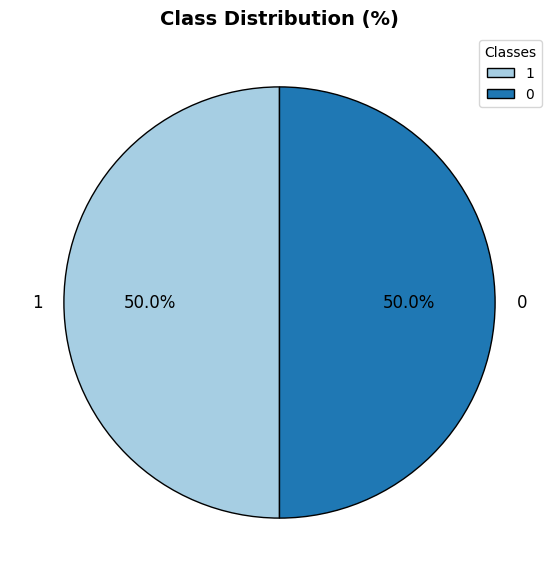

In [ ]:
# ----------------- Compute Class Distribution -----------------
class_distribution = train_csv['label'].value_counts()

# ----------------- Define Pie Chart Properties -----------------
colors = plt.cm.Paired.colors[:len(class_distribution)]  # Generate colors dynamically

plt.figure(figsize=(7, 7))  # Set figure size
wedges, texts, autotexts = plt.pie(
    class_distribution,
    labels=class_distribution.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)

# ----------------- Add Chart Customizations -----------------
plt.title("Class Distribution (%)", fontsize=14, fontweight='bold')
plt.legend(wedges, class_distribution.index, title="Classes", loc="best")

for text in texts + autotexts:
    text.set_fontsize(12)  # Enhance text readability

plt.show()

In [ ]:
# ----------------- Display Image Shapes -----------------
for i in range(10):
    image_path = os.path.join(main_dir, train_csv.file_name[i])

    try:
        image = plt.imread(image_path)
        shape = image.shape

        print(f"Image {i+1}: {train_csv.file_name[i]}")
        print(f" - Shape: {shape}")
        print(f" - Image Path: {image_path}\n")

    except FileNotFoundError:
        print(f"⚠ Warning: File not found - {image_path}")

    except Exception as e:
        print(f"⚠ Error loading image {train_csv.file_name[i]}: {e}")

Image 1: /content/dataset/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg
 - Shape: (768, 512, 3)
 - Image Path: /content/dataset/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg

Image 2: /content/dataset/train_data/041be3153810433ab146bc97d5af505c.jpg
 - Shape: (768, 512, 3)
 - Image Path: /content/dataset/train_data/041be3153810433ab146bc97d5af505c.jpg

Image 3: /content/dataset/train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg
 - Shape: (512, 768, 3)
 - Image Path: /content/dataset/train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg

Image 4: /content/dataset/train_data/8542fe161d9147be8e835e50c0de39cd.jpg
 - Shape: (512, 768, 3)
 - Image Path: /content/dataset/train_data/8542fe161d9147be8e835e50c0de39cd.jpg

Image 5: /content/dataset/train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg
 - Shape: (768, 512, 3)
 - Image Path: /content/dataset/train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg

Image 6: /content/dataset/train_data/25ea852f30594bc5915eb929682af429.jpg
 - Shape: (768, 512, 3)
 - Imag

Convert labels to **string**

In [ ]:
# ----------------- Convert Label Column to String -----------------
train_csv["label"] = train_csv["label"].astype(str)

# ----------------- Display First Few Rows -----------------
train_csv.head()

,file_name,label
0,/content/dataset/train_data/a6dcb93f596a432491...,1
1,/content/dataset/train_data/041be3153810433ab1...,0
2,/content/dataset/train_data/615df26ce9494e5db2...,1
3,/content/dataset/train_data/8542fe161d9147be8e...,0
4,/content/dataset/train_data/5d81fa12bc3b4cea8c...,1


Image data **generator**

In [ ]:
# ----------------- Initialize Data Generator -----------------
data_generator = ImageDataGenerator(rescale=1/255, validation_split=0.3)

In [ ]:
# ----------------- Create Training Data Generator -----------------
train_generator = data_generator.flow_from_dataframe(
    train_csv,
    x_col="file_name",   # Path to images
    y_col="label",       # Labels (as string)
    target_size=(512, 512),  # Resize images
    batch_size=32,
    class_mode="binary",  # Binary classification
    subset="training"  # Training split
)

Found 55965 validated image filenames belonging to 2 classes.


In [ ]:
# ----------------- Create Validation Data Generator -----------------
valid_generator = data_generator.flow_from_dataframe(
    train_csv,
    x_col="file_name",   # Path to images
    y_col="label",       # Labels (as string)
    target_size=(512, 512),  # Resize images
    batch_size=32,
    class_mode="binary",  # Binary classification
    subset="validation"  # Validation split
)

Found 23985 validated image filenames belonging to 2 classes.


Data **Visuailtion**

In [ ]:
# ----------------- Function to Display Images -----------------
def show_images(data, n_rows=5, n_cols=5, figsize=(25, 15)):
    """
    Displays a grid of images from a given dataset.

    Args:
        data (tf.data.Dataset): The dataset containing images and labels.
        n_rows (int): Number of rows in the grid.
        n_cols (int): Number of columns in the grid.
        figsize (tuple): Figure size for the plot.

    Returns:
        None
    """
    images, labels = next(iter(data))  # Get a batch of images and labels

    plt.figure(figsize=figsize)  # Create figure

    n_image = 0  # Initialize image counter

    for i in range(n_rows):
        for j in range(n_cols):
            if n_image < len(images):
                plt.subplot(n_rows, n_cols, n_image + 1)
                plt.imshow(images[n_image])
                plt.axis('off')
                plt.title("AI" if labels[n_image] == 1.0 else "Human")
                n_image += 1

    plt.show()  # Display images

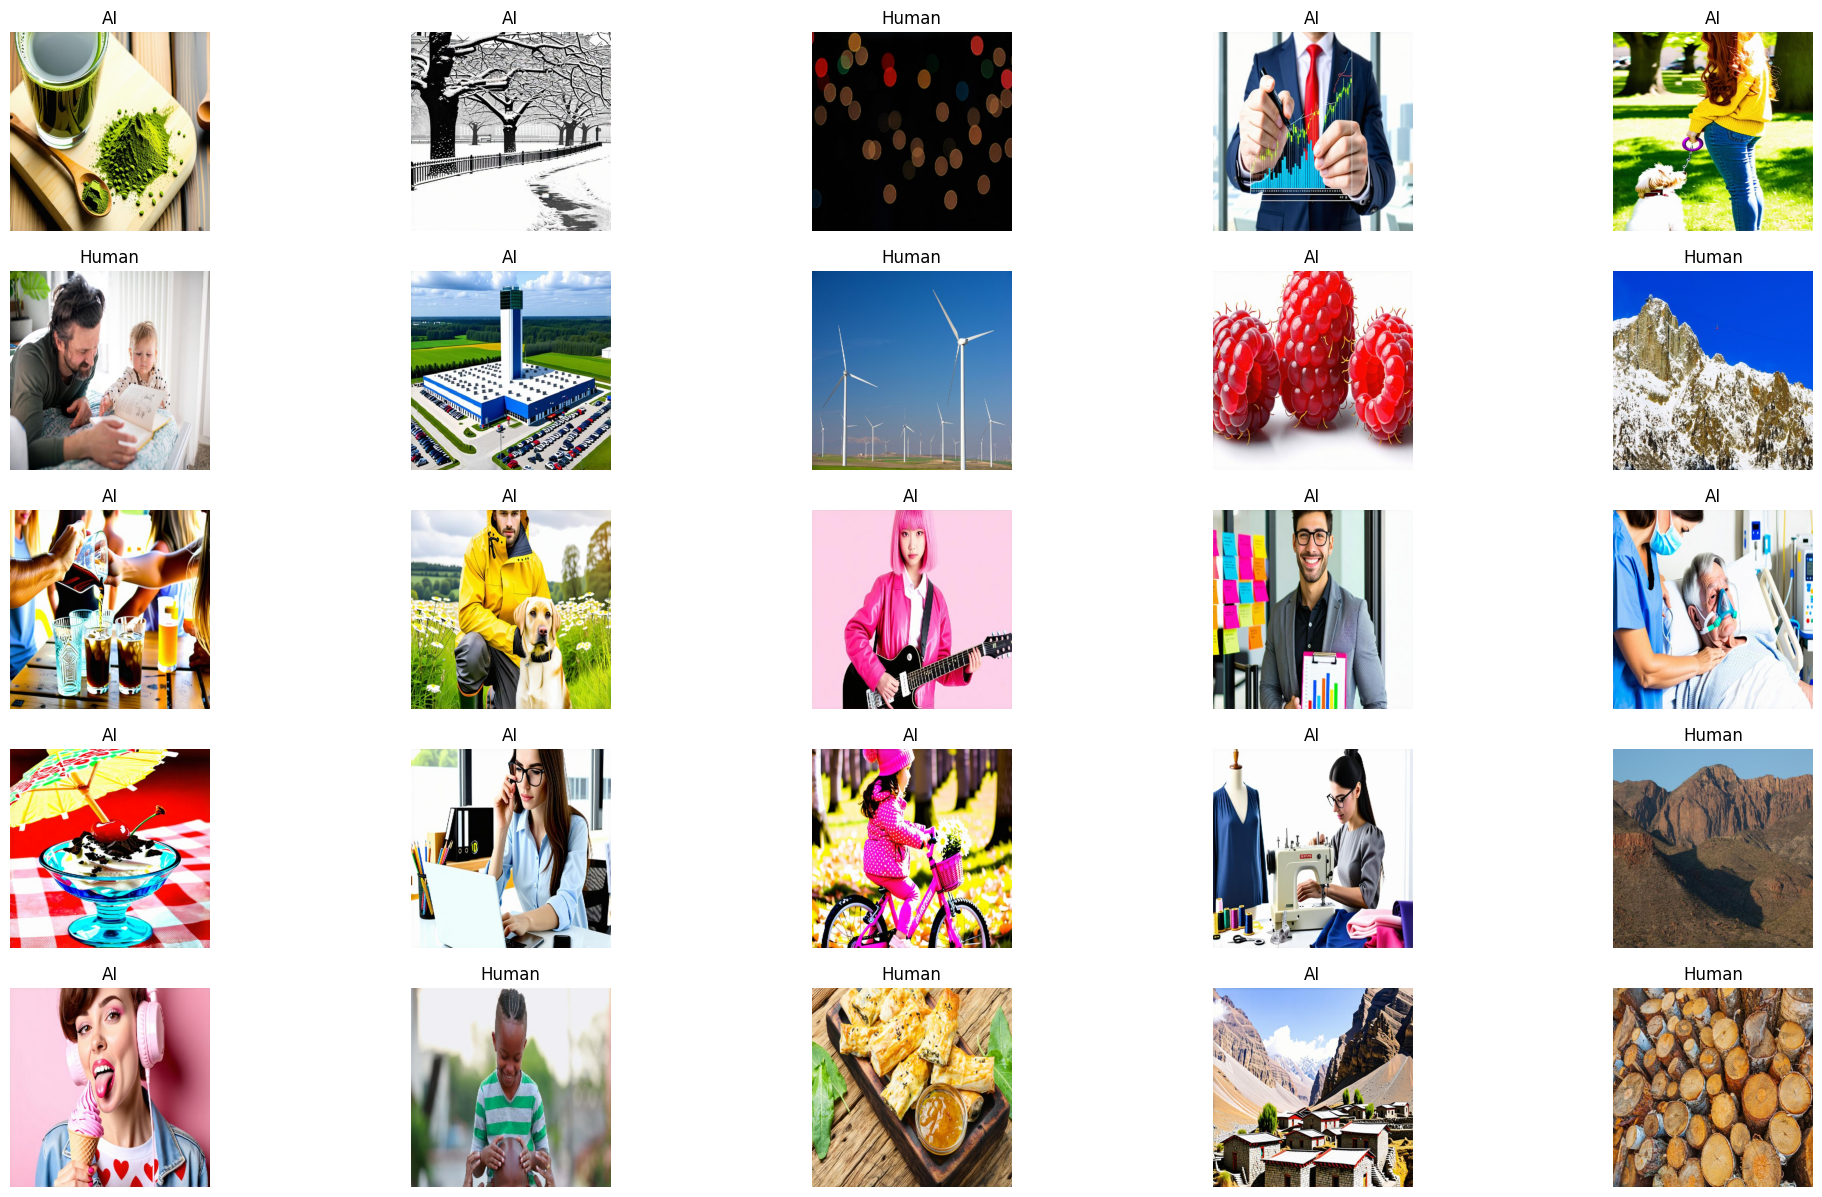

In [ ]:
# ----------------- Visualize Images -----------------
show_images(valid_generator)

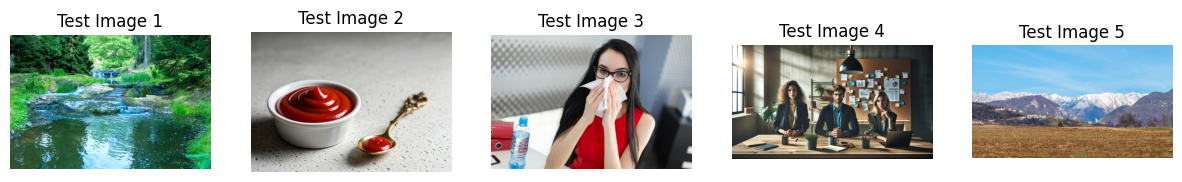

In [ ]:
# ----------------- Function to Display Test Images -----------------
def show_test_images(df, num_images=5):
    sample_images = df.sample(num_images, random_state=42)["file_path"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Test Image {i+1}")

    plt.show()

# ----------------- Show Test Images -----------------
show_test_images(test_csv)

In [ ]:
# ----------------- Define model path -----------------
resnet50v2_path = '/kaggle/input/ai-vs-human/tensorflow2/default/1/ResNet50V2-AIvsHumanGenImages.keras'

# ----------------- Load or create model -----------------
if os.path.exists(resnet50v2_path):
    resnet50_model = keras.models.load_model(resnet50v2_path, compile=True)
    resnet50_model.trainable = False
else:
    resnet50_base_model = ResNet50V2(
        input_shape=(512, 512, 3),
        include_top=False,
        weights='imagenet'
    )
    resnet50_base_model.trainable = False

    resnet50_model = keras.Sequential([
        resnet50_base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ], name='ResNet50V2-AIvsHumanGenImages')

    resnet50_model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
        ]
    )

# ----------------- Model summary -----------------
resnet50_model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "ResNet50V2-AIvsHumanGenImages"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 16, 16, 2048)        │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,630,401 (90.14 MB)

 Trainable params: 65,601 (256.25 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# ----------------- Define history log path -----------------
resnet50v2_history_path = '/kaggle/input/ai-vs-human/tensorflow2/default/1/ResNet50V2-AIvsHumanGenImages-Logs.csv'

# ----------------- Load or train model -----------------
if os.path.exists(resnet50v2_history_path):
    resnet50v2_history = pd.read_csv(resnet50v2_history_path)  # Load training logs
else:
    resnet50_model_history = resnet50_model.fit(
        train_generator,
        epochs=10,
        steps_per_epoch=55965 // 32,
        validation_data=valid_generator,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
            keras.callbacks.ModelCheckpoint('ResNet50V2-AIvsHumanGenImages.keras', save_best_only=True),
            keras.callbacks.CSVLogger('ResNet50V2-AIvsHumanGenImages-Logs.csv', append=True),
            keras.callbacks.TerminateOnNaN()
        ]
    )
    resnet50v2_history = pd.DataFrame(resnet50_model_history.history)
    resnet50v2_history.to_csv('ResNet50V2-AIvsHumanGenImages-Logs.csv', index=False)

# ----------------- Display history preview -----------------
resnet50v2_history.head()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1219s 679ms/step - accuracy: 0.8874 - loss: 0.2560 - precision: 0.8859 - recall: 0.8896 - val_accuracy: 0.9532 - val_loss: 0.1207 - val_precision: 0.9544 - val_recall: 0.9519
Epoch 2/10
   1/1748 ━━━━━━━━━━━━━━━━━━━━ 11:17 388ms/step - accuracy: 0.9688 - loss: 0.1374 - precision: 0.9444 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



1748/1748 ━━━━━━━━━━━━━━━━━━━━ 298s 170ms/step - accuracy: 0.9688 - loss: 0.1374 - precision: 0.9444 - recall: 1.0000 - val_accuracy: 0.9528 - val_loss: 0.1210 - val_precision: 0.9512 - val_recall: 0.9545
Epoch 3/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1019s 583ms/step - accuracy: 0.9509 - loss: 0.1264 - precision: 0.9522 - recall: 0.9493 - val_accuracy: 0.9581 - val_loss: 0.1065 - val_precision: 0.9654 - val_recall: 0.9502
Epoch 4/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 271s 155ms/step - accuracy: 1.0000 - loss: 0.0317 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9580 - val_loss: 0.1066 - val_precision: 0.9654 - val_recall: 0.9501
Epoch 5/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1017s 552ms/step - accuracy: 0.9584 - loss: 0.1056 - precision: 0.9584 - recall: 0.9585 - val_accuracy: 0.9604 - val_loss: 0.1028 - val_precision: 0.9723 - val_recall: 0.9477
Epoch 6/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 270s 154ms/step - accuracy: 0.9375 - loss: 0.1312 - precision: 0.8947 - recall: 1.0000 - val_accuracy: 

,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0.922908,0.189169,0.922873,0.922939,0.953179,0.120710,0.954355,0.951889
1,0.968750,0.137414,0.944444,1.000000,0.952762,0.121012,0.951222,0.954473
2,0.950369,0.125583,0.951534,0.949085,0.958099,0.106528,0.965435,0.950221
3,1.000000,0.031705,1.000000,1.000000,0.958015,0.106563,0.965430,0.950054
4,0.957842,0.108632,0.957906,0.957769,0.960350,0.102757,0.972284,0.947720


train **evaluation**

In [ ]:
# ----------------- Evaluate model on training data -----------------
train_loss, train_accuracy, *_ = resnet50_model.evaluate(train_generator)  # Ignore extra metrics

# ----------------- Display training accuracy and loss -----------------
print(f"Accuracy on train data: {train_accuracy:.2%} | Loss: {train_loss:.4f}")

1749/1749 ━━━━━━━━━━━━━━━━━━━━ 643s 367ms/step - accuracy: 0.9695 - loss: 0.0760 - precision: 0.9789 - recall: 0.9597
Accuracy on train data: 97.00% | Loss: 0.0754


learning **curve**

   accuracy      loss  precision    recall  val_accuracy  val_loss  \
0  0.922908  0.189169   0.922873  0.922939      0.953179  0.120710   
1  0.968750  0.137414   0.944444  1.000000      0.952762  0.121012   
2  0.950369  0.125583   0.951534  0.949085      0.958099  0.106528   
3  1.000000  0.031705   1.000000  1.000000      0.958015  0.106563   
4  0.957842  0.108632   0.957906  0.957769      0.960350  0.102757   

   val_precision  val_recall  
0       0.954355    0.951889  
1       0.951222    0.954473  
2       0.965435    0.950221  
3       0.965430    0.950054  
4       0.972284    0.947720  


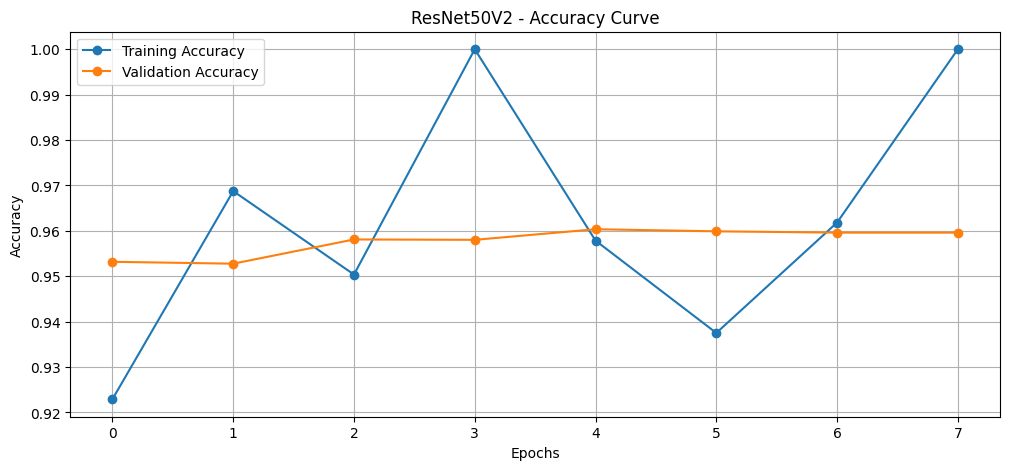

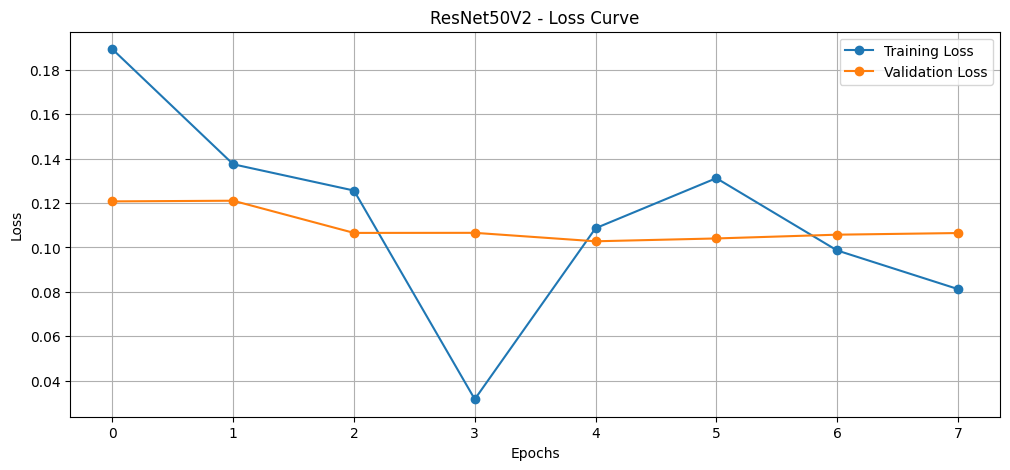

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import keras

# ----------------- Define history log path -----------------
resnet50v2_history_path = 'ResNet50V2-AIvsHumanGenImages-Logs.csv'  # Save in writable directory

# ----------------- Load or train model -----------------
if os.path.exists(resnet50v2_history_path):
    resnet50v2_history = pd.read_csv(resnet50v2_history_path)  # Load training logs
else:
    resnet50_model_history = resnet50_model.fit(
        train_generator,
        epochs=10,
        steps_per_epoch=55965 // 32,
        validation_data=valid_generator,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
            keras.callbacks.ModelCheckpoint('ResNet50V2-AIvsHumanGenImages.keras', save_best_only=True),
            keras.callbacks.CSVLogger(resnet50v2_history_path, append=True),  # Fixed path
            keras.callbacks.TerminateOnNaN()
        ]
    )
    resnet50v2_history = pd.DataFrame(resnet50_model_history.history)
    resnet50v2_history.to_csv(resnet50v2_history_path, index=False)  # Save in writable directory

# ----------------- Display history preview -----------------
print(resnet50v2_history.head())

# ----------------- Check if training history exists -----------------
if os.path.exists(resnet50v2_history_path):
    try:
        # ----------------- Load training history logs -----------------
        history_df = pd.read_csv(resnet50v2_history_path)

        # ----------------- Convert all numeric values safely -----------------
        for col in history_df.columns:
            history_df[col] = pd.to_numeric(history_df[col], errors='coerce')

        # ----------------- Plot Accuracy Curve -----------------
        plt.figure(figsize=(12, 5))
        plt.plot(history_df['accuracy'], label='Training Accuracy', marker='o')
        plt.plot(history_df['val_accuracy'], label='Validation Accuracy', marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('ResNet50V2 - Accuracy Curve')
        plt.legend()
        plt.grid()
        plt.show()

        # ----------------- Plot Loss Curve -----------------
        plt.figure(figsize=(12, 5))
        plt.plot(history_df['loss'], label='Training Loss', marker='o')
        plt.plot(history_df['val_loss'], label='Validation Loss', marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('ResNet50V2 - Loss Curve')
        plt.legend()
        plt.grid()
        plt.show()

    except Exception as e:
        print(f"Error loading history file: {e}")

else:
    # ----------------- Handle missing history file -----------------
    print("History file not found.")

test **generator**

In [ ]:
# ----------------- Prepare test data generator -----------------
test_generator = data_generator.flow_from_dataframe(
    dataframe=test_csv,
    x_col="file_path",   # Column containing image file paths
    y_col=None,         # No labels for test data
    target_size=(512, 512),  # Resize images to match model input
    batch_size=32,
    class_mode=None,     # No class labels needed for prediction
    shuffle=False        # Maintain order for evaluation
)

Found 5540 validated image filenames.


Test **predictor**

In [ ]:
# ----------------- Make predictions on test data -----------------
predictions = resnet50_model.predict(test_generator)  # Get model predictions

# Convert probabilities to binary labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



174/174 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step


Submission **file**

In [ ]:
# ----------------- Create submission file -----------------
submission_csv = pd.DataFrame({
    'id': test_csv['id'],  # Image IDs from test data
    'label': predicted_labels.flatten()  # Flatten predictions to match CSV format
})

# Save predictions to a CSV file
submission_csv.to_csv('submission.csv', index=False)

# Display the first few rows of the submission file
print(submission_csv.head())

                                                  id  label
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg      0
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg      0
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg      0
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg      0
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg      0


In [ ]:
# ----------------- Count predicted labels -----------------
# Display the count of each unique label in the submission file
submission_csv['label'].value_counts()

,count
label,
0,4624
1,916
